In [5]:
using DelimitedFiles
using DataFrames

RootFolder = "/home/nepero27178/Documents/University/Masters/" * 
    "LadderHubbardSC/Project/HartreeFock/" * 
    "simulations/heatmap/Setup=B[128]/"
FilePath = RootFolder * "AF.txt"
Data = readdlm(FilePath, ';')
DF = DataFrame(Data[2:end,:], Data[1,:])
"done"

"done"

In [6]:
vv = DF.v
yy = [
    eval(Meta.parse(vv[i]))["w0"] 
    for i in 1:length(vv)
]
insertcols!(DF, 10, :w0 => yy)
"done"

"done"

In [7]:
VV = unique(DF.V)
δδ = zeros(length(VV))
MM = zeros(length(VV))
xerr = VV[1]-VV[2]
yerr = unique(DF.δ)[2]-unique(DF.δ)[1]
for (i,V) in enumerate(VV)
    lDF = filter(:V => x -> x==V, DF)
    yy = lDF.w0
    M = maximum(yy)
    MM[i] = M
    δδ[i] = filter(:w0 => x -> x==M, lDF).δ[1]
end

In [8]:
ww = zeros(length(VV))
for (i,V) in enumerate(VV)
    if i==1 | i==length(VV)
        ww[i] = yerr
    elseif i > 1 & i < length(VV)
        d = (δδ[i+1] - δδ[i-1]) / (2 * xerr)
        ww[i] = sqrt(yerr^2 + (d * xerr)^2)
    end
end

In [10]:
using LsqFit
f(x, p) = p[1] .+ p[2] .* x.^p[3]
p0 = [0, 0.2, 0.5]
fit = curve_fit(f, VV[2:end-1], δδ[2:end-1], ww[2:end-1], p0)
a, b, n = fit.param

3-element Vector{Float64}:
 -0.05055291691122034
  0.24514032681594758
  0.3972398042740278

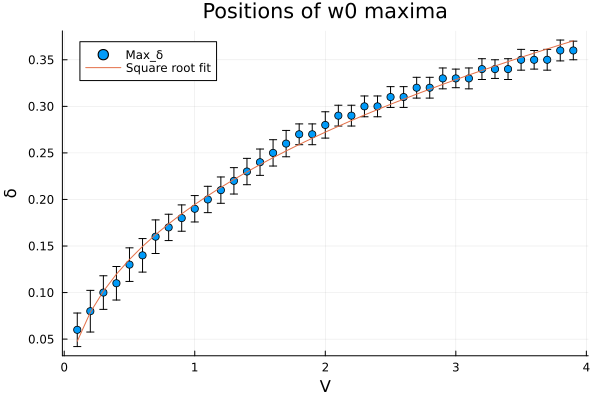

In [11]:
using Plots
scatter(
    VV[2:end-1], δδ[2:end-1],
    yerror=ww[2:end-1],
    xlabel='V', ylabel='δ',
    label="Max_δ",
    title="Positions of w0 maxima"
)
plot!(
    VV[2:end-1], a .+ b .* VV[2:end-1] .^ n,
    label="Square root fit"
)

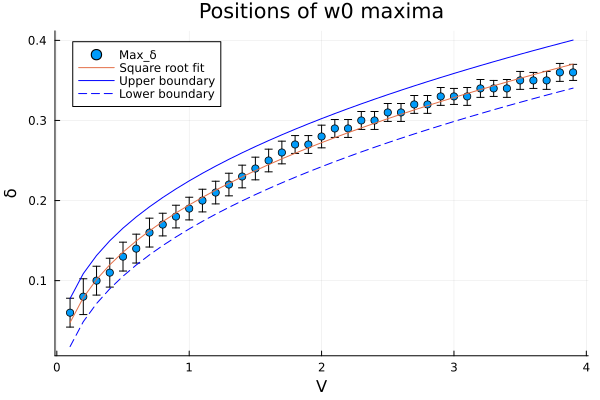

In [12]:
uu = a .+ b .* VV[2:end-1] .^ n .+ 0.03
ll = a .+ b .* VV[2:end-1] .^ n .- 0.03
plot!(
    VV[2:end-1], uu,
    label="Upper boundary",
    color=:blue
)
plot!(
    VV[2:end-1], ll,
    label="Lower boundary",
    color=:blue,
    ls=:dash
)

In [13]:
SrcFolder = "/home/nepero27178/Documents/University/Masters/" * 
    "LadderHubbardSC/Project/HartreeFock/" * 
    "src/modules/"
include(SrcFolder * "methods-simulating.jl")

function SpecialScan(
    VV::Vector{Float64},	        	# Non-local attraction
    uu::Vector{Float64},
    ll::Vector{Float64},
    Steps::Int64,
    t::Float64=1.0,
    U::Float64=4.0,
    L::Int64=128,
    β::Float64=100.0,
    p::Int64,
    Δv::Dict{String,Float64},
    Δn::Float64,
    g::Float64;
    FilePathOut::String="",             # Output file
    RenormalizeHopping::Bool=true       # Conditional renormalization of t
)

    # Warn user of memory-heavy simulations detection
    Iterations = length(UU) * length(VV) * length(LL) * length(ββ) * Steps
    if FilePathOut == "" && Iterations > 200
        @warn "No output file specified and more than 200 simulations " * 
            "request detected. Simulations results are going to be stored " *
            "in your memory. Consider specifying a `FilePathOut` and " *
            "unloading your memory."
    end

    # Get Hartree Fock Parameters labels
    HFPs = ["m", "w0", "wp"]
    
    # File coditional initialization (otherwise, just append)
    if FilePathOut != "" && InitializeFile
            Header = "t;U;V;Lx;β;δ;v;Q;ΔT\n"
        write(FilePathOut, Header)
    end

    # HF iterations
    i = 1    
    for (j,V) in enumerate(VV), 
        
        δδ = range(ll[j], uu[j], Steps)        
        Parameters::Dict{String,Float64} = Dict([
            "t" => t,
            "U" => U,
            "V" => V
        ])

        L = [Lx, Lx]
        
        for δ in δδ
            printstyled(
                "\e[2K\e[1GRun ($i/$Iterations): " *
                "$Phase HF at t=$t, U=$U, V=$V, L=$Lx, β=$β, δ=$δ", 
                color=:yellow
            )
            ResultsVector::Matrix{Any} = [0 0]  # Dummy placeholder
                    
            # Run routine, all positional arguments here must be false
            HFResults = RunHFAlgorithm(
                Phase,Parameters,L,0.5+δ,β,
                p,Δv,Δn,g;
                RenormalizeHopping
            )
            
            v::Dict{String,Float64} = Dict([
                key => HFResults[1][key] for key in HFPs
            ])
            Qs::Dict{String,Float64} = Dict([
                key => HFResults[2][key] for key in HFPs
            ])        
            ResultsVector = hcat(ResultsVector[:,3:end], [v Qs HFResults[3]])
            push!(ResultsDF, ResultsVector)

            i += 1

            # Append to initialized or existing file
            if FilePathOut != ""
                open(FilePathOut, "a") do io
                    writedlm(io, ResultsVector, ';')
                end
            end
        end
    end
    
    printstyled(
        "\e[2K\e[1GDone! Data saved at " * FilePathOut * "\n", color=:green
    )
end

LoadError: syntax: optional positional arguments must occur at end around In[13]:6

1530

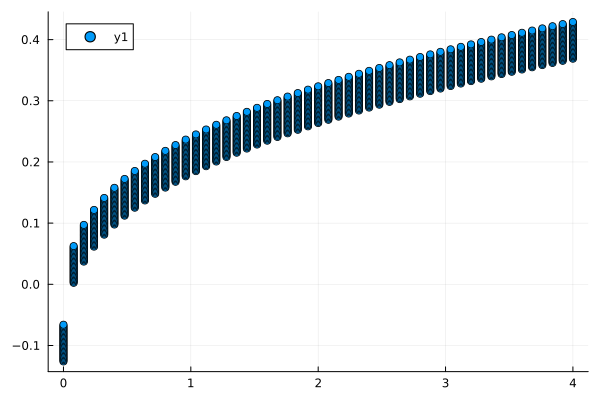

In [15]:
FilePathS =  "/home/nepero27178/Documents/University/Masters/" * 
    "LadderHubbardSC/Project/HartreeFock/" * 
    "simulations/special-scan/2025-11-25-MaxFinder-AF.txt"
DataS = readdlm(FilePathS, ';')
DFS = DataFrame(DataS[2:end,:], DataS[1,:])
S = scatter(DFS.V, DFS.δ)
myVec = [V for V in 0.0:0.08:4.0]
print(length(myVec) * 30)
S